# Summary
In this notebook a deep neural network will be trained on images in order to output a steering angle for a self driving car, driving in a simulation.

This is part of the udacity self driving car nanodegree.

# Data Generation

Udacity provides a Unity3D based simulator, where you can drive a car around a race track and record images from three different cameras mounted to the car. One in the center of the windscreen, one in the left and one in the right.

I drove two times around the track in the clockwise direction and two times in the counter clockwise direction and tried to stay in the middle of the track. I used the mouse to steer to generate better steering angles. Then I tried to capture some special situations, mostly when the car is at the very side of the track and is steered towards the center. I also captured more data at the brigde and the corner with gravel at its side.

# Loading the Data

In [ ]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import urllib.request
from urllib.request import urlretrieve
import zipfile

In [ ]:
%matplotlib inline

## Download the data if not yet existing

In [ ]:
def download_file(filename, source):
    if not os.path.exists("./" + filename):
        print("Images not yet downloaded, downloading...")
        urlretrieve(source, filename)
        print("extracting...")
        zip_ref = zipfile.ZipFile(filename, 'r')
        zip_ref.extractall(".")
        zip_ref.close()    
        print("done!")
    else:
        print("Images already downloaded.")

In [ ]:
download_file("train_images.zip", "https://s3-eu-west-1.amazonaws.com/fabian.hertwig.carnddata/train_images.zip")

In [ ]:
download_file("extra_train_images.zip", "https://s3-eu-west-1.amazonaws.com/fabian.hertwig.carnddata/extra_train_images.zip")

In [ ]:
log = pd.read_csv("./train_images/driving_log.csv", names = ["center", "left", "right", "steering", "acceleration", "break", "speed"])

In [ ]:
log.head()

The original images are sampled at 60fps, but I do not want to use too similar images. So I will only read every sixth image and therefore reduce the samplerate to 10 fps.

In [ ]:
images = []
steering_angles = []


def load_images(df, source_folder, camera, steering_add, image_step = 1, add_fliped_image = False):
    for i in range(0, len(df), image_step):
        name = df.loc[i, camera].split("/")[-1]
        path = source_folder + name

        image = cv2.imread(path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        steering_angle = log.loc[i, "steering"]
        steering_angle += steering_add

        images.append(image)
        steering_angles.append(steering_angle)
        
        if add_fliped_image:
            image_flipped = np.fliplr(image)
            steering_angle_flipped = -steering_angle
            images.append(image_flipped)
            steering_angles.append(steering_angle_flipped)
    

In [ ]:
load_images(log, "./train_images/IMG/", "center", 0, image_step=3, add_fliped_image=True)

In [ ]:
load_images(log, "./train_images/IMG/", "left", 0.2, image_step=3, add_fliped_image=True)

In [ ]:
load_images(log, "./train_images/IMG/", "right", -0.2, image_step=3, add_fliped_image=True)

In [ ]:
plt.imshow(images[0])

In [ ]:
images = np.array(images)
images.shape

In [ ]:
steering_angles = np.array(steering_angles)
len(steering_angles)

# Model Architecture

The model architecture used is the same as the [NVidea Model for self driving car steering](https://arxiv.org/pdf/1604.07316v1.pdf).

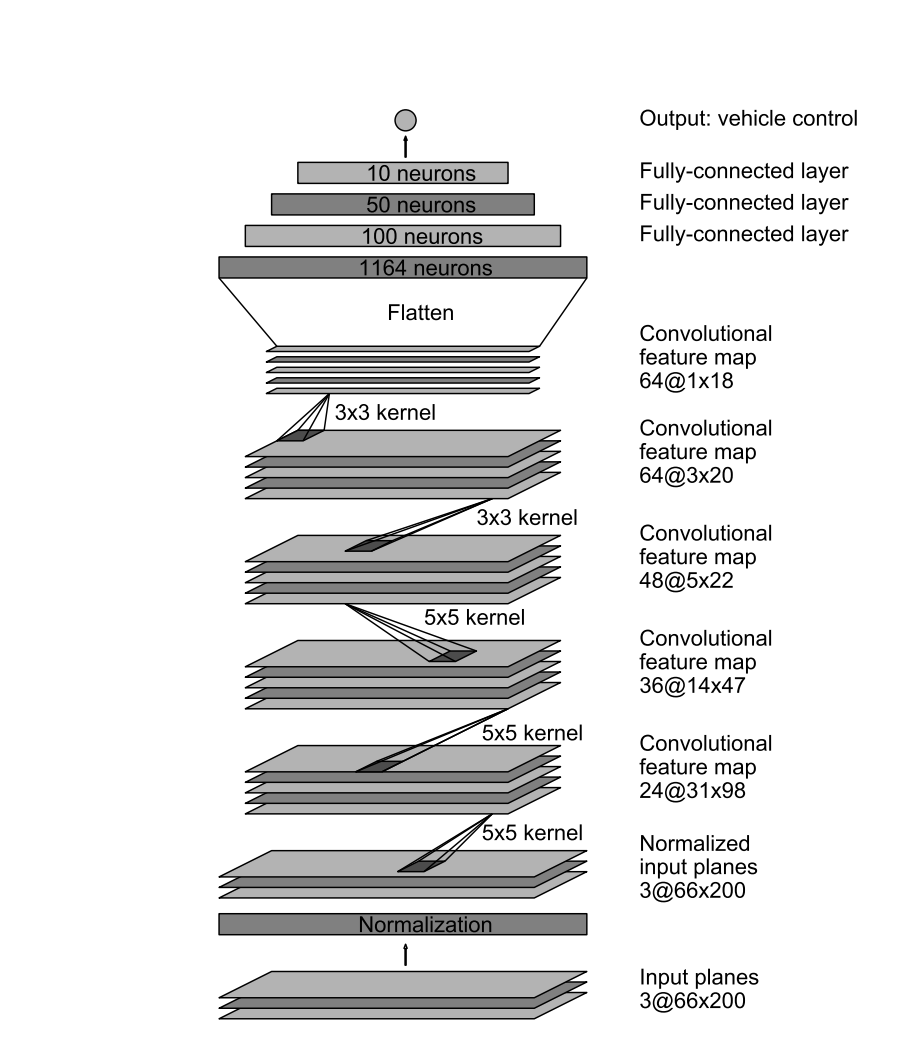


In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Convolution2D, MaxPooling2D, BatchNormalization, Flatten, Lambda, Cropping2D
from keras import callbacks

In [ ]:
X_train = images
y_train = steering_angles

In [ ]:
model = Sequential()

model.add(Cropping2D(cropping=((50,10), (0,0)), data_format="channels_last", input_shape=images.shape[1:4]))
model.add(Lambda(lambda x: (x / 255.0) - 0.5))

model.add(BatchNormalization(epsilon=0.001, mode=2, axis=1))

model.add(Convolution2D(24,5,5,border_mode='valid', activation='relu', subsample=(2,2)))
model.add(Convolution2D(36,5,5,border_mode='valid', activation='relu', subsample=(2,2)))
model.add(Convolution2D(48,5,5,border_mode='valid', activation='relu', subsample=(2,2)))
model.add(Convolution2D(64,3,3,border_mode='valid', activation='relu', subsample=(1,1)))
model.add(Convolution2D(64,3,3,border_mode='valid', activation='relu', subsample=(1,1)))
model.add(Flatten())
model.add(Dense(1164, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(1, activation='tanh'))

model.compile(optimizer="adam", loss="mse")

In [ ]:
model.summary()

These callbacks will save the best model at each epoch. That means if the model improved at the current epoch, it gets saved. The early stop callback will stop training if it does not improve on the validation set.

In [ ]:
#Save the model after each epoch if the validation loss improved.
save_best = callbacks.ModelCheckpoint("./model.h5", monitor='val_loss', verbose=1, 
                                     save_best_only=True, mode='min')

#stop training if the validation loss doesn't improve for 5 consecutive epochs.
early_stop = callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0005, patience=3, 
                                     verbose=0, mode='auto')


# Training

In [ ]:
epochs = 15
history_object = model.fit(X_train, y_train, batch_size=128, shuffle=True, validation_split=0.2, nb_epoch=epochs, callbacks=[save_best, early_stop])

In [ ]:
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()